In [1]:
elastic_rods_dir = '../../../../../elastic_rods/python/'
weaving_dir = '../../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_double_side_view)
import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.1756505993328395
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('regular_torus_1', thickness, width, weaving_dir)
#  [ ear 396, ear 412, nose 497]

0.058550199777613166 0.004098513984432921


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = get_double_side_view(curved_linkage)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), …

In [8]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/regular_torus_1/regular_torus_1_dof.npy'))

In [9]:
# curved_linkage.setExtendedDoFsPSRL(np.load('results/regular_torus_1_dof.npy'))

In [10]:
curved_linkage.attraction_weight = 1e-5

In [9]:
# rw = 10
# sw = 0

In [10]:
E0 = curved_linkage.designParameterSolve_energy()
l0 = curved_linkage.totalRestLength()

In [11]:
iterateData, dpo = stage_1_optimization(curved_linkage, 0.1, 0., curved_linkage_view, E0 = E0, l0 = l0, niter = 2000)

In [11]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [12]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00153321	1.75481	1.75481	1	1
1	0.000226653	0.0401487	0.0401487	1	1
2	0.000199936	0.00640175	0.00640175	1	1
3	0.000188208	0.00264716	0.00264716	1	1
4	0.000181531	0.00129701	0.00129701	1	1
5	0.00017827	0.000638547	0.000638547	1	1
6	0.000177021	0.000332328	0.000332328	1	1
7	0.000176612	0.000167984	0.000167984	1	1
8	0.00017648	7.84652e-05	7.84652e-05	1	1
9	0.000176436	3.53612e-05	3.53612e-05	1	1
10	0.000176421	1.57622e-05	1.57622e-05	1	1
11	0.000176416	6.66791e-06	6.66791e-06	1	1
12	0.000176415	2.39998e-06	2.39998e-06	1	1
13	0.000176414	8.15489e-07	8.15489e-07	1	1
14	0.000176414	2.98372e-07	2.98372e-07	1	0
15	0.000176414	1.22177e-07	1.22177e-07	1	0
16	0.000176414	2.94738e-12	2.94738e-12	1	0


In [14]:
# curved_linkage_view.update(scalarField=colors)

In [14]:
import vis
from matplotlib import cm

# stress = curved_linkage.maxBendingStresses()
stress = curved_linkage.twistingStresses()
rangeMin = np.stack(stress).min()
rangeMax = np.stack(stress).max()
sf = vis.fields.ScalarField(curved_linkage, stress, colormap=cm.magma, vmin=rangeMin, vmax=rangeMax)
heights = curved_linkage.visualizationGeometryHeightColors()
colors = sf.colors()
# colors[heights < heights.mean()] = np.ones_like(sf.colors()[heights < heights.mean()]) * 0.5
curved_linkage_view.update(scalarField = colors)

In [67]:
rangeMin, rangeMax

(0.0005744484061331955, 9.056448489183289)

In [17]:
# stress

In [18]:
# len(stress[0])

In [1]:
# stress

In [15]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rest_length_weight=20, smoothing_weight=0)

In [ ]:
optimizer, opt_iterateData, weight_change_iters, target_weight, solverStatusList = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, [], -5, 1, True)

rl_regularization_weight 20.0
smoothing_weight 0.0
stage 2 optimization with attraction weight 1e-05


In [69]:
curved_optimizer_energy = curved_linkage.energy()
validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
validation_curved_linkage.attraction_weight = 1e-7
with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
validation_curved_energy = validation_curved_linkage.energy()
print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

NameError: name 'optimizer' is not defined

In [ ]:
validation_curved_view = get_double_side_view(validation_curved_linkage)
validation_curved_view.show()

In [ ]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [ ]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(validation_curved_linkage)

In [ ]:
# set_joint_vector_field(validation_curved_linkage, validation_curved_view, joint_normals)

In [105]:
os.chdir(save_path)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)
from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_double_side_view)

9576 9576
write stress
write stress
Min Width  0.058550199777613166
Scale:  85.39680511750814
num seg per rod 168
num seg per rod 12
num seg per rod 168
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12
num seg per rod 12


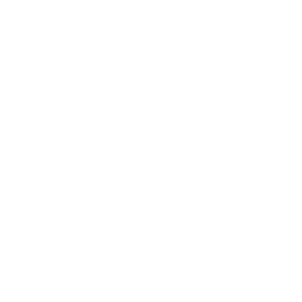

In [14]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME + '_new_pw_linear', io.RIBBON_NAME + '_new_pw_linear', False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = True, width = max(io.RIBBON_CS), write_stress = True)
os.chdir(save_path)

## Contact Optimization

In [ ]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

In [ ]:
curved_linkage.setExtendedDoFsPSRL(np.load('results/regular_torus_1/regular_torus_1_dof.npy'))

In [ ]:
curved_linkage.attraction_weight = 1e-5

In [ ]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [ ]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = [])

In [ ]:
optimizer.setLinkageAttractionWeight(1e-5)

Coefficient of Friction Percentiles 50, 75, 90:  0.33128503508119467 0.5391073232428792 0.7295100776787234


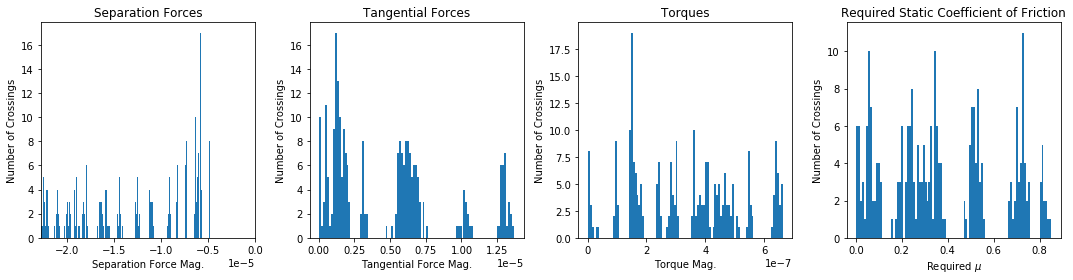

In [23]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [ ]:
contact_optimization(optimizer, curved_linkage_view, -1, 1e4)

In [ ]:
structure_view_2 = get_structure_analysis_view(curved_linkage)
structure_view_2.show()